<a href="https://colab.research.google.com/github/dsskonuru/satellite-constellation-optimization-ga-qa/blob/master/Satellite_Constellation_Optimization_(GA%2BQA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dimod
!pip install networkx 
!pip install dwave-neal

     |████████████████████████████████| 4.8MB 2.8MB/s 
     |████████████████████████████████| 399kB 2.8MB/s 


>$\text{Ising:} \qquad  E(\bf{s}|\bf{h},\bf{J})
= \left\{ \sum_{i=1}^N h_i s_i + \sum_{i<j}^N J_{i,j} s_i s_j  \right\}$

>$\small E \quad {\longrightarrow} \quad Objective \; function \; (to \; be \; minimized) 
\\ \small s_i \quad {\longrightarrow} \quad Subconstellation 
\\ \small h_i \quad {\longrightarrow} \quad Coverage \; of \; the \; subconstellation
\\ \small J_{i,j} \quad {\longrightarrow} \quad Penality \; for \; pairs \; having \; a \; satellite \; in \; common$

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import networkx as nx

import dimod
import neal

### Complexity of the problem

Suppose you have a set of ``N`` satellites and ``k`` targets on Earth that you
want to observe. Each of your satellites has varying capabilities for Earth
observation; in particular, the amount of ground that they can observe for a
set amount of time is different. Since there are ``k`` targets, you would like
to have ``k`` constellations to monitor said targets. 

Note: We are assuming that ``N`` is a multiple of ``k``.

In [0]:
N = 12
k = 4 # number of targets

subconstellation_size = N // k  # satellites per constellation

Each of the 12 satellites (labelled 0-11) has a coverage score. This could be calculated as the percentage of time  that the Earth region is in range of the satellite. We are assuming a random value in this case, this can be replaced by real values in a particular application.

In [105]:
coverage = {}
for i in range(N):
  np.random.seed(i)
  coverage[i] = np.random.randint(0, 100)/100
print(coverage)

{0: 0.44, 1: 0.37, 2: 0.4, 3: 0.24, 4: 0.46, 5: 0.99, 6: 0.1, 7: 0.47, 8: 0.67, 9: 0.92, 10: 0.09, 11: 0.25}


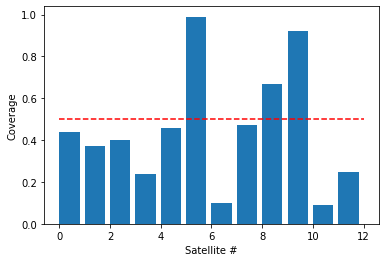

In [29]:
score_threshold = 0.5
lists = sorted(coverage.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.xlabel("Satellite #")
plt.ylabel("Coverage")
plt.hlines(score_threshold, 0, N, linestyles='dashed', colors='r')
plt.bar(x, y, align='edge')
plt.show()

In [103]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

print('# possible subconstellations: ', nCr(12,3))

# possible subconstellations:  220.0


In [0]:
import itertools

subconstellations = {} # create dict of subconstellations and its coverage

for subconstellation in itertools.combinations(range(N), N//k):
    score = sum(coverage[v] for v in subconstellation) / subconstellation_size

    if score < score_threshold:
        continue

    subconstellations[subconstellation] = score

The ``score_threshold`` is used to determine bad constellations. Constellations with coverage less than this value is not considered. It is assigned an arbitrarily picked number i.e `0.4`. 

In [107]:
print('# subconstellations after search space pruning: ',len(subconstellations))

# subconstellations after search space pruning:  134


In [0]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(list(subconstellations.items()))

for c0, c1 in itertools.combinations(list(subconstellations.keys()), 2):
    if set(c0).isdisjoint(set(c1)):
        G.add_edge(c0,c1)

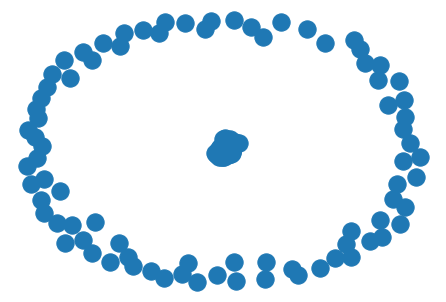

In [33]:
nx.draw(G)

### Formulating the problem


In [0]:
N = 30
k = 6 # number of targets

subconstellation_size = N // k  # satellites per constellation

In [79]:
coverage = {}
for i in range(N):
  np.random.seed(i**2)
  coverage[i] = np.random.randint(0, 100)/100
print(coverage)

score_threshold = 0.4

{0: 0.44, 1: 0.37, 2: 0.46, 3: 0.92, 4: 0.41, 5: 0.04, 6: 0.05, 7: 0.42, 8: 0.68, 9: 0.67, 10: 0.08, 11: 0.66, 12: 0.6, 13: 0.35, 14: 0.28, 15: 0.35, 16: 0.32, 17: 0.47, 18: 0.25, 19: 0.83, 20: 0.92, 21: 0.13, 22: 0.31, 23: 0.09, 24: 0.19, 25: 0.51, 26: 0.52, 27: 0.22, 28: 0.21, 29: 0.36}


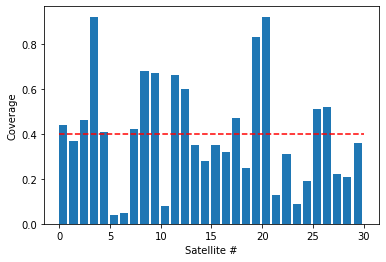

In [80]:
lists = sorted(coverage.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.xlabel("Satellite #")
plt.ylabel("Coverage")
plt.hlines(score_threshold, 0, N, linestyles='dashed', colors='r')
plt.bar(x, y, align='edge')
plt.show()

In [100]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

print('# possible subconstellations: ', nCr(30,5))

# possible subconstellations:  142506.0


In [101]:
subconstellations = {} # create dict of subconstellations and its coverage

for subconstellation in itertools.combinations(range(N), N//k):
    score = sum(coverage[v] for v in subconstellation) / subconstellation_size

    if score < score_threshold:
        continue

    subconstellations[frozenset(subconstellation)] = score

print('# subconstellations after search space pruning: ',len(subconstellations))

# subconstellations after search space pruning:  71972


### Genetic Algorithm

In [0]:
def init_pop(sol_per_pop):
  population = []
  for i in range(sol_per_pop):
    constellation = [np.random.choice(list(subconstellations.keys())) for j in range(k)]
    population.append(constellation)
  return population

In [0]:
def cal_fitness(population):
  fitness = []

  for con in population:
    coverage = sum([subconstellations[subcon] for subcon in con])

    # penalty multiple subcons sharing the same satellite
    for a, b in itertools.combinations(con, 2): 
      if not a.isdisjoint(b):
        coverage-=1

    fitness.append(coverage)
      
  return fitness

In [0]:
def select_mating_pool(population, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = []
    for parent_num in range(num_parents):
        max_fitness_idx = fitness.index(max(fitness))
        parents.append(population[max_fitness_idx])
        fitness[max_fitness_idx] = -999
    return parents

In [0]:
def crossover(parents, offspring_size):
    offsprings = []
    # The point at which crossover takes place between two parents. Usually it is at the center.
    crossover_point = np.random.randint(k)

    for i in range(offspring_size):
        # Index of the first parent to mate.
        parent1_idx = i%len(parents)
        # Index of the second parent to mate.
        parent2_idx = (i+1)%len(parents)
        offspring = parents[parent1_idx][:crossover_point]+parents[parent2_idx][crossover_point:]
        offsprings.append(offspring)

    return offsprings

In [0]:
def mutation(offspring_crossover):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(len(offspring_crossover)):
        # The random value to be added to the gene.
        random_idx = np.random.randint(N*k)
        random_value = np.random.choice(list(subconstellations.keys()))
        offspring_crossover[idx] = offspring_crossover[idx][:random_idx] + [random_value] + offspring_crossover[idx][random_idx+1:]
    return offspring_crossover

In [0]:
sol_per_pop = 50
num_generations = 2000

fitness_g = []
new_population = init_pop(sol_per_pop)
num_parents_mating = sol_per_pop // 2

for generation in range(num_generations):
    
    # Measuring the fitness of each chromosome in the population.
    fitness = cal_fitness(new_population)

    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, offspring_size=sol_per_pop-len(parents))

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
    new_population = parents + offspring_mutation

    fitness_g.append(max(fitness))

# Getting the best solution after iterating finishing all generations.
fitness = cal_fitness(new_population)
best_match_idx = np.where(fitness == np.max(fitness))[0][0]


In [83]:
print('Coverage :', max(fitness))
print('Constellation :', new_population[best_match_idx])

Coverage : 1.004
Constellation : [frozenset({0, 10, 15, 20, 28}), frozenset({2, 3, 11, 21, 23}), frozenset({0, 1, 10, 15, 20}), frozenset({4, 5, 14, 19, 25}), frozenset({7, 12, 17, 18, 26}), frozenset({8, 9, 13, 16, 24}), frozenset({6, 7, 12, 17, 26})]


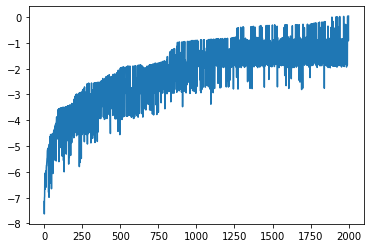

In [84]:
import matplotlib.pyplot as plt

plt.plot(fitness_g)

### Quantum Annealing

In [0]:
s = set()
for con in new_population:
    for subcon in con:    
      s.add(subcon)

subcons = {i:subconstellations[i] for i in list(s)}

In [86]:
len(subcons)

56

In [0]:
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
bqm.add_variables_from(subcons)    

In [0]:
for c0, c1 in itertools.combinations(bqm.variables, 2):
    if c0.isdisjoint(c1):
        continue
    bqm.add_interaction(c0, c1, 2)

In [0]:
# choosing num_constellations variables 
bqm.update(dimod.generators.combinations(bqm, k))

In [0]:
# sample from the bqm using simulated annealing
sampleset = neal.Neal().sample(bqm, num_reads=100).aggregate()

constellations = [constellation
                  for constellation, chosen in sampleset.first.sample.items()
                  if chosen]

In [91]:
print('Coverage : ', sampleset.first.energy)
print('Constellation : ', constellations)

Coverage :  3.102000000000544
Constellation :  [frozenset({6, 7, 12, 17, 26}), frozenset({4, 5, 14, 19, 25}), frozenset({1, 20, 22, 28, 29}), frozenset({0, 2, 11, 15, 23}), frozenset({8, 9, 13, 16, 24})]
